Web scraping using Selenium first and then Scarpy. 
Page: https://citas.in/temas/amor/?page=2

# Selenium

In [16]:
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver import Firefox
from selenium.webdriver.support.events import EventFiringWebDriver, AbstractEventListener
import pandas as pd
import csv
from selenium.webdriver.common.keys import Keys  
from selenium.webdriver.common.by import By
from IPython.display import Image
import logging

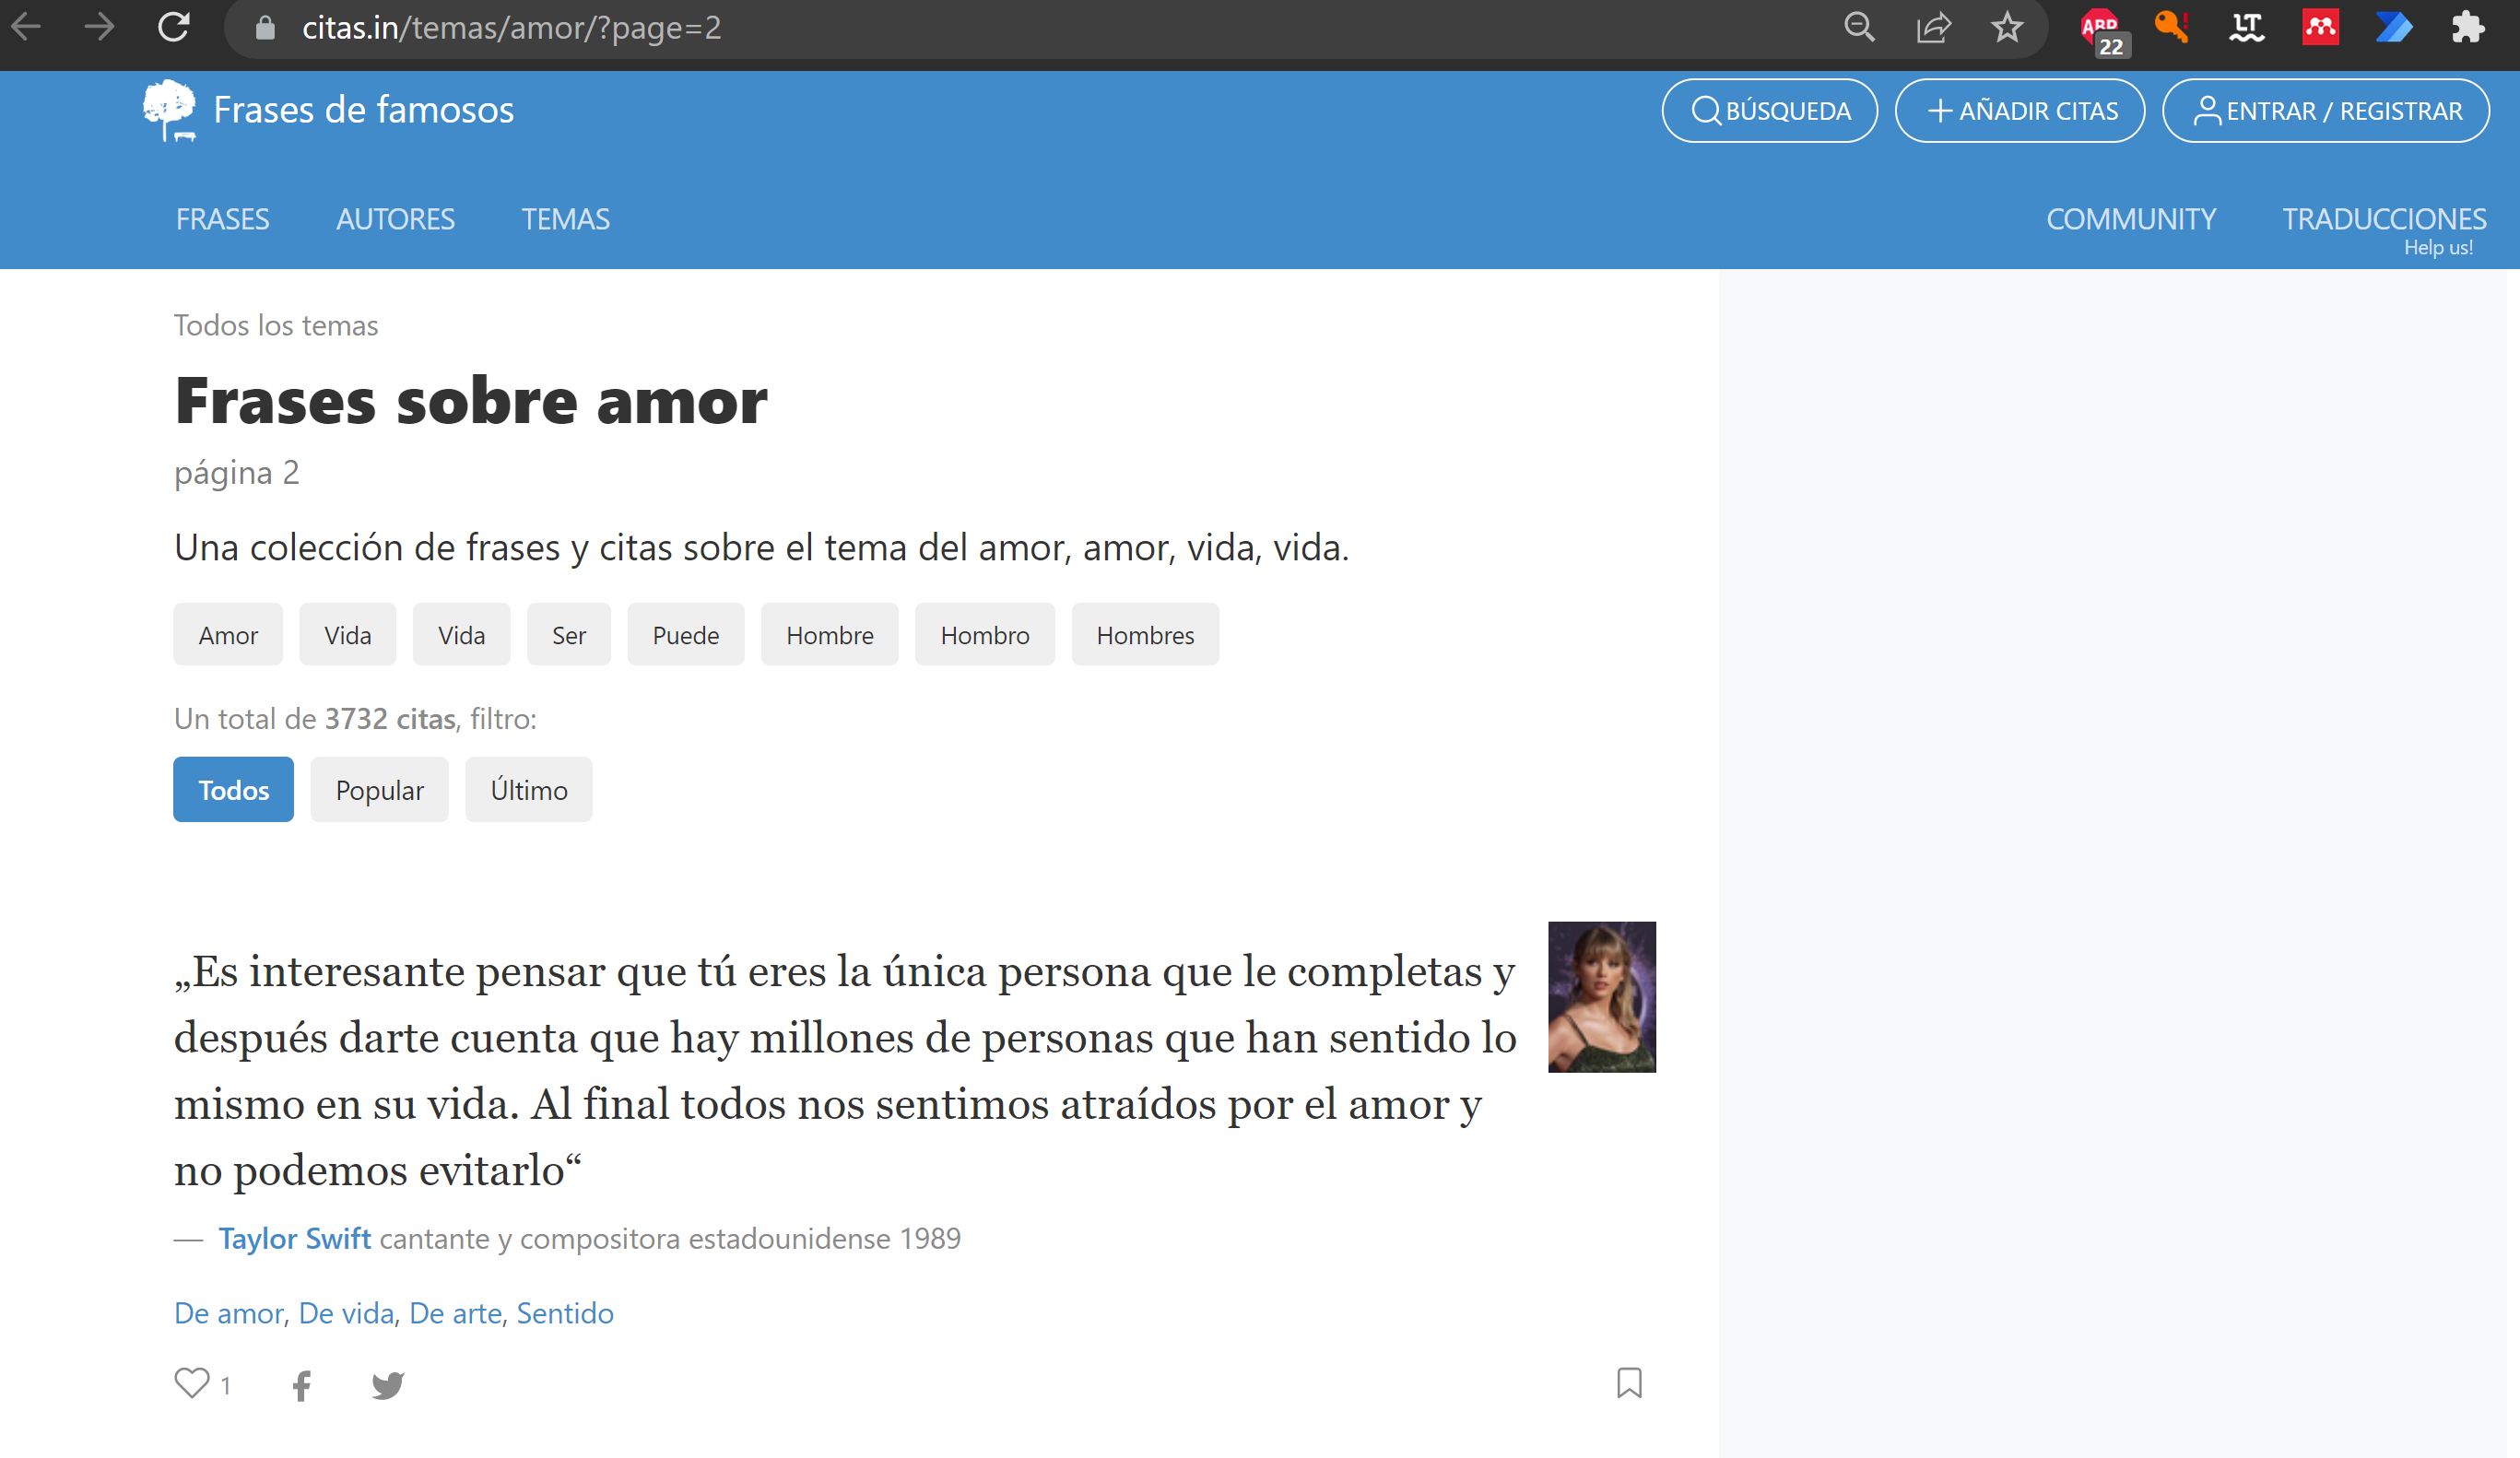

In [17]:
Image(filename='Web.png') 

In [18]:
from webdriver_manager.chrome import ChromeDriverManager
driver = webdriver.Chrome(ChromeDriverManager().install()) 

In [19]:
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.support import expected_conditions as EC

web = 'https://citas.in/temas/amor/?page=2'
driver_path = 'D:/chromedriver'

options = webdriver.ChromeOptions()
options.add_argument('--headless')

driver = webdriver.Chrome(options=options, service=Service(ChromeDriverManager().install()))
driver.get(web)

result = []

items = wait(driver, 1).until(EC.presence_of_all_elements_located((By.XPATH, './/div[contains(@class, "quote-body")]')))
for item in items:
    # find name
    name = item.find_element(By.XPATH, './/p[@class="blockquote-origin"]/a')
    formattedName = name.text.replace('—  ', '')

    # find text
    text = item.find_element(By.XPATH, './/p[@class="blockquote-text"]')
    formattedText = text.text.replace('“', '').replace('„', '')
    
    # find tags
    tags = item.find_element(By.XPATH, './/div[@class="blockquote-footnote"]')
    formattedTags = tags.text
    
    result.append({ 'Text': formattedText, 'Name': formattedName, 'Tags': formattedTags})
    
driver.quit()

In [20]:
print(result)

[{'Text': '«Todo es amor… todo es amor. Con el amor llega la comprensión. Con la comprensión llega la paciencia. Y entonces el tiempo se detiene. Y todo es ahora.»', 'Name': 'Brian L. Weiss', 'Tags': 'De amor, Comprensión, Paciencia'}, {'Text': 'El Arte es un hijo al cual ves nacer y crecer, dándole todo tu amor y atención hasta los últimos días de tu vida.', 'Name': 'Jhoan Roa', 'Tags': 'De amor, De vida, De arte'}, {'Text': 'Porque usted sabe, general, que mover un país, por pequeño que sea, es obra de gigantes. Y quien no se sienta gigante de amor, o de valor, o de pensamiento, o de paciencia, no debe emprenderla', 'Name': 'José Martí', 'Tags': 'De amor, País, Valor, Paciencia'}, {'Text': 'Es cierto, no hay planes celestiales ni infernales. Pero cuando uno está enamorado busca explicar el rechazo en términos de intriga. El amor es fatal para el pensamiento. La gente empieza a creer en gualichos, en maldiciones, en conexiones mágicas. Siga un consejo: no se enamore.', 'Name': 'Alejan

In [21]:
#Create the dataframe with the data collected
import pandas as pd
df_Selenium = pd.DataFrame(result)
df_Selenium

,Text,Name,Tags
0,«Todo es amor… todo es amor. Con el amor llega...,Brian L. Weiss,"De amor, Comprensión, Paciencia"
1,"El Arte es un hijo al cual ves nacer y crecer,...",Jhoan Roa,"De amor, De vida, De arte"
2,"Porque usted sabe, general, que mover un país,...",José Martí,"De amor, País, Valor, Paciencia"
3,"Es cierto, no hay planes celestiales ni infern...",Alejandro Dolina,"De amor, De gente"
4,"Si Eva hubiera escrito el Génesis, ¿cómo sería...",Eduardo Galeano,"De amor, De Dios, De dolor, De mentira"
...,...,...,...
95,EL AMENAZADO\n\nEs el amor. Tendré que ocultar...,Jorge Luis Borges,"De amor, De muerte, De mujeres, De hombres"
96,DESPEDIDA DE UN PAISAJE\n\nNo le reprocho a la...,Wisława Szymborska,"De amor, De vida, De dolor, De tristeza"
97,… la mujer inventó el amor sin compañero. Aven...,Isabel Allende,"De amor, De mujeres"
98,No hagas cualquier cosa sólo para ser famoso. ...,Zac Efron,De amor


# Scarpy

In [22]:
# Notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import platform

In [23]:
#Import Scrapy
try:
    import scrapy
except:
    !pip install scrapy
    import scrapy
from scrapy.crawler import CrawlerProcess

In [24]:
#Configure a pipeline
import json
from crochet import setup
from twisted.internet import reactor
from scrapy.utils.project import get_project_settings

class JsonWriterPipeline(object):

    def open_spider(self, spider):
        self.file = open('quoteresult.jl', 'w')

    def close_spider(self, spider):
        self.file.close()

    def process_item(self, item, spider):
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item

In [25]:
#Definir the spider
from scrapy.crawler import CrawlerRunner
class QuotesSpider(scrapy.Spider):
    name = "quotes"
    start_urls = [
        'https://citas.in/temas/amor/?page=2',
        'https://citas.in/temas/amor/?page=3',
    ]
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'ITEM_PIPELINES': {'__main__.JsonWriterPipeline': 1}, 
        'FEED_FORMAT':'json',                                 
        'FEED_URI': 'quoteresult.json'                        
    }
    
    def parse(self, response):
        for quote in response.css('div.blockquote'):
            yield {
                'text': quote.css('p.blockquote-text a::text').extract_first(),  
                'autor': quote.css('p.blockquote-origin a::text').extract_first(),
                'tags': quote.css('div.blockquote-footnote a::text').extract(),  
            }

In [26]:
setup()
crawler = CrawlerRunner(get_project_settings())  
crawler.crawl(QuotesSpider)                          


In [27]:
df_Scrapy = pd.read_json('quoteresult.jl', lines=True)
df_Scrapy

""


In [28]:
df_Scrapy.columns = ['Text', 'Name', 'Tags']
df_Scrapy

ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

In [ ]:
df_Scrapy["Text"] = df_Scrapy["Text"].replace({'„':''}, regex=True)
df_Scrapy

## Recommended web pages

##### Selenium:

https://medium.com/@jb.ranchana/web-scraping-with-selenium-in-python-amazon-search-result-part-1-f09c88090932

https://stackoverflow.com/questions/63369229/selenium-webdriver-for-chrome-not-working-on-jupyterlab-mac

 https://stackoverflow.com/questions/72773206/selenium-python-attributeerror-webdriver-object-has-no-attribute-find-el

https://stackoverflow.com/questions/65291985/attributeerror-options-object-has-no-attribute-binary-error-invoking-headle

 https://namespaceit.com/blog/selenium-python-attributeerror-webdriver-object-has-no-attribute-find-element-by-name

 https://pythonbasics.org/selenium-get-html/

 https://www.wake-up-neo.net/es/python/recupera-todos-los-enlaces-href-usando-selenium-en-python/822552195/

https://www.octoparse.es/tutorial-7/xpath

https://stackoverflow.com/questions/68070757/how-to-find-a-lot-of-elements-that-contains-a-certain-text-with-selenium-python


https://es.acervolima.com/extraer-tabla-del-sitio-web-usando-python-selenium/

https://www.codegrepper.com/code-examples/python/get+table+selenium+python+pandas

https://medium.com/@jb.ranchana/web-scraping-with-selenium-in-python-amazon-search-result-part-1-f09c88090932



##### Scrapy:

https://www.jitsejan.com/using-scrapy-in-jupyter-notebook

https://stackoverflow.com/questions/71548957/twisted-internet-error-reactoralreadyinstallederror-reactor-already-installed